# Import the necessary ML Libraries

In [1]:
# Libraries for managing dataset
import pandas as pd
import numpy as np

In [2]:
# The defaultdict of collections library
from collections import defaultdict as dd

In [3]:
# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Libraries of the ML models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import LinearSVC as LSVM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import CategoricalNB as NBC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression as LR

In [5]:
# libraries for performance evaluation
from sklearn.metrics import zero_one_loss
from sklearn.metrics import jaccard_score # equal to accuracy_score for binary classification
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
# from sklearn.metrics import plot_roc_curve
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import recall_score
from sklearn.metrics import recall_score, make_scorer

In [6]:
# Libraries for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Load the final_combined_extracted_octapeptide_features into Pandas DF

In [7]:
# The first column of our dataset is "unnamed", which can be removed by any of the methods below:
# Method 1 using "index_col=0" as parameter in pd.read_csv() 
# Method 2 using df.loc[:, ~df.columns.str.contains('^Unnamed')]

df = pd.read_csv("../datasets/final_combined_extracted_features_dataset/final_combined_extracted_octapeptide_features.csv", 
                 index_col=0)

# Split the Dataset into Training, Validation, and Testing Sets and Assign X and y Variables

In [8]:
training_set, validation_set, testing_set = np.split(df.sample(frac=1, random_state=123), [int(.7*len(df)), int(.8*len(df))])

X_training = training_set.drop(["cleavage Status"], axis=1)
y_training = training_set["cleavage Status"].copy().map({"cleaved": 1, "uncleaved": 0})

X_validation = validation_set.drop(["cleavage Status"], axis=1)
y_validation = validation_set["cleavage Status"].copy().map({"cleaved": 1, "uncleaved": 0})

X_testing = testing_set.drop(["cleavage Status"], axis=1)
y_testing = testing_set["cleavage Status"].copy().map({"cleaved": 1, "uncleaved": 0})

# Model Training and Performance Evaluation on the Testing Set

In [9]:
## Instantiating the classifier classes and storing in a list
clf_list = [
    (LSVM(random_state=0, tol=1e-5, C=5), "LinearSVC"),
    (LDA(solver="svd", tol=1e-8), "LinearDiscriminantAnalysis"),
    (GBC(n_estimators=800, learning_rate=1.0, max_depth=1, random_state=0, 
         tol=1e-10, ccp_alpha=0.0), "GradientBoostingClassifier"),
    (KNN(n_neighbors=4, n_jobs=-1, metric="minkowski", leaf_size=30, p=2, 
         weights="distance"), "KNeighorsClassifier"),
    (NBC(alpha=1), "CategoricalNB"),
    (DTC(criterion="gini", splitter="best", max_depth=None, ccp_alpha=0.0), "DecisionTreeClassifier"),
    (MLPC(hidden_layer_sizes=100, activation ="relu", solver="adam", alpha=0.0001, 
          learning_rate="adaptive", max_iter=200, tol=1e-4, momentum=0.9, epsilon=1e-8,), "MLPClassifier"),
    (Perceptron(penalty="l2", alpha=0.0000001, max_iter=4000, tol=1e-7, eta0=2, n_jobs=-1), "Perceptron"),       
    (LR(random_state=0, penalty="l2", tol=1e-3, C=0.99, solver="lbfgs", max_iter=150,
       n_jobs=-1), "LogisticRegression")]

scores = dd(list)

for clf, name in clf_list:
    clf.fit(X_training, y_training)
    y_pred = clf.predict(X_testing)
    scores["Classifier"].append(name)   

    for metric in [balanced_accuracy_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", " ").capitalize()
        scores[score_name].append(metric(y_testing, y_pred))

    for metric in [precision_score, recall_score, f1_score, roc_auc_score, jaccard_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", " ").capitalize()
        scores[score_name].append(metric(y_testing, y_pred, average="macro"))       

C:\Users\HP\anaconda3\envs\dl_env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\HP\anaconda3\envs\dl_env\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [10]:
scores 

defaultdict(list,
            {'Classifier': ['LinearSVC',
              'LinearDiscriminantAnalysis',
              'GradientBoostingClassifier',
              'KNeighorsClassifier',
              'CategoricalNB',
              'DecisionTreeClassifier',
              'MLPClassifier',
              'Perceptron',
              'LogisticRegression'],
             'Balanced accuracy  ': [0.9279808625099215,
              0.883918334950172,
              0.8978304965164476,
              0.6919701913749008,
              0.8410904841696798,
              0.7456290237234324,
              0.9119245524296675,
              0.5027173913043478,
              0.9003659934738513],
             'Precision  ': [0.8511471095011329,
              0.883918334950172,
              0.9013880855986119,
              0.6945600500533493,
              0.8955031189283158,
              0.7334314629342497,
              0.9083234985575662,
              0.9217279726261762,
              0.9132657415467595],

# Convert the Result to a DF and Save

In [11]:
score_df = pd.DataFrame(scores).set_index("Classifier")
score_df.astype(float).round(decimals=3).to_csv("../results/Models_Performance_Metrics_On_Testing_Set.csv")
#score_df.to_excel("../results/Models_Performance_Metrics_On_Evaluation_Set.xlsx")
score_df.astype(float).round(decimals=3)

,Balanced accuracy,Precision,Recall,F1,Roc auc,Jaccard
Classifier,,,,,,
LinearSVC,0.928,0.851,0.928,0.883,0.928,0.798
LinearDiscriminantAnalysis,0.884,0.884,0.884,0.884,0.884,0.801
GradientBoostingClassifier,0.898,0.901,0.898,0.900,0.898,0.825
KNeighorsClassifier,0.692,0.695,0.692,0.693,0.692,0.572
CategoricalNB,0.841,0.896,0.841,0.865,0.841,0.775
DecisionTreeClassifier,0.746,0.733,0.746,0.739,0.746,0.618
MLPClassifier,0.912,0.908,0.912,0.910,0.912,0.841
Perceptron,0.503,0.922,0.503,0.463,0.503,0.424
LogisticRegression,0.900,0.913,0.900,0.907,0.900,0.836


# Plot of Confusion Matrix of the Models using the Testing Set

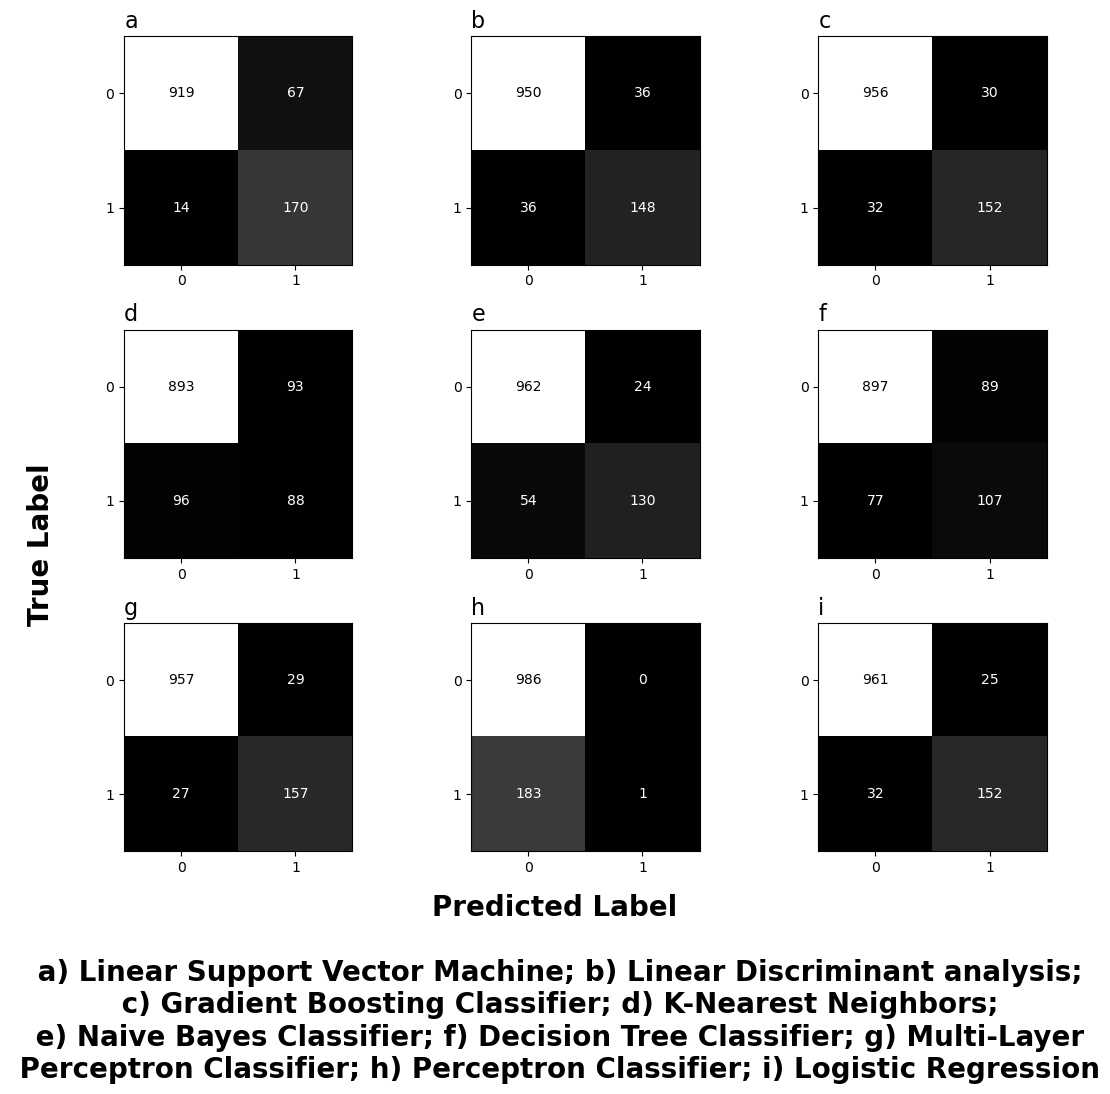

In [12]:
titles = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 11))

for (clf, name), ax, title in zip(clf_list, axes.flatten(), titles):
    ConfusionMatrixDisplay.from_estimator(clf, X_testing, y_testing, ax=ax, cmap='Greys_r', colorbar=False)
    ax.set_title(label=title, loc="left", fontsize=16,)
    #ax.set_title(label=name, loc="left", fontsize=18) we can use this if we want the titles to show as name of the classifiers
    ax.grid(False)
    ax.set(xlabel=None)
    ax.set(ylabel=None)

fig.supxlabel("Predicted Label\n\n a) Linear Support Vector Machine; b) Linear Discriminant analysis;\n c) Gradient Boosting Classifier; d) K-Nearest Neighbors;\n e) Naive Bayes Classifier; f) Decision Tree Classifier; g) Multi-Layer\n Perceptron Classifier; h) Perceptron Classifier; i) Logistic Regression", 
              fontsize=20, fontweight="bold")  
fig.supylabel("True Label", fontsize=20, fontweight="bold")    
fig.tight_layout() 
#fig.savefig('../results/Combined_Confusion_Matrix_of_Models_on_Evaluation_Set.jng', dpi=1200)
plt.savefig('../results/Confusion_Matrix_of_the_Models_on_Testing_Set.png', dpi=1200)
plt.show()

# ROC Curves for Both Testing Set, Validation Set and Training Set

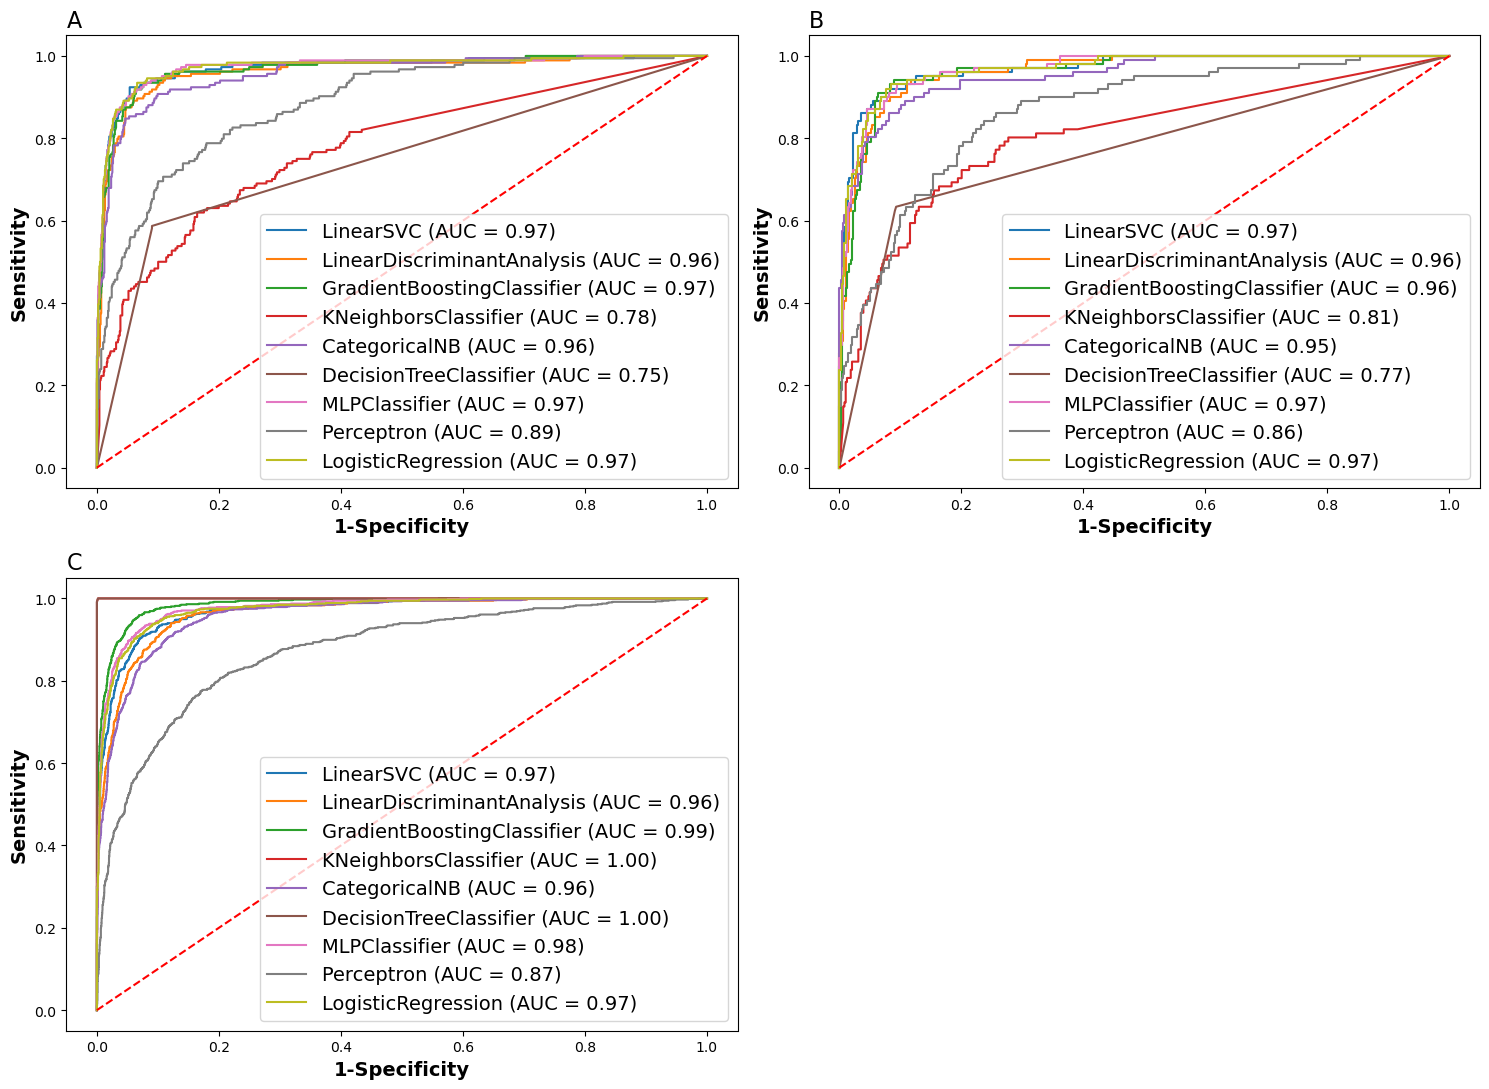

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[15,11])

for clf, name in clf_list:
    RocCurveDisplay.from_estimator(clf, X_testing, y_testing, ax=ax1)
    RocCurveDisplay.from_estimator(clf, X_validation, y_validation, ax=ax2)
    RocCurveDisplay.from_estimator(clf, X_training, y_training, ax=ax3)
    
ax1.set_title("A", fontsize=16, loc="left")
ax1.set_xlabel("1-Specificity", fontsize=14, fontweight="bold")
ax1.set_ylabel("Sensitivity", fontsize=14, fontweight="bold")
ax1.plot([0,1],[0,1], "r--") # adding a diagonal
ax1.legend(fontsize=14)
ax1.grid(False)

ax2.set_title("B", fontsize=16, loc="left")
ax2.set_xlabel("1-Specificity", fontsize=14, fontweight="bold")
ax2.set_ylabel("Sensitivity", fontsize=14, fontweight="bold")
ax2.plot([0,1],[0,1], "r--") # adding a diagonal
ax2.legend(fontsize=14)
ax2.grid(False)

ax3.set_title("C", fontsize=16, loc="left")
ax3.set_xlabel("1-Specificity", fontsize=14, fontweight="bold")
ax3.set_ylabel("Sensitivity", fontsize=14, fontweight="bold")
ax3.plot([0,1],[0,1], "r--") # adding a diagonal
ax3.legend(fontsize=14)
ax3.grid(False)

ax4.remove()
    
fig.tight_layout()
plt.savefig('../results/ROC_Curves_for_Testing_Set_Validation_Set_and_Training_Set.png', dpi=1200)
plt.show()

# Plot of Feature Importance for the Gradient Boosting Classifier

In [14]:
## Retrieving feature importabnce from the GB_classifier
importance = pd.Series(clf_list[2][0].feature_importances_, name="Gini")

## Retrieving feature names
feature_names = pd.Series(X_training.columns, name="Feature")

## Combining the feature names and Gini values into a DataFrame
df1 = pd.concat([feature_names, importance], axis=1, names=["Feature", "Gini"])

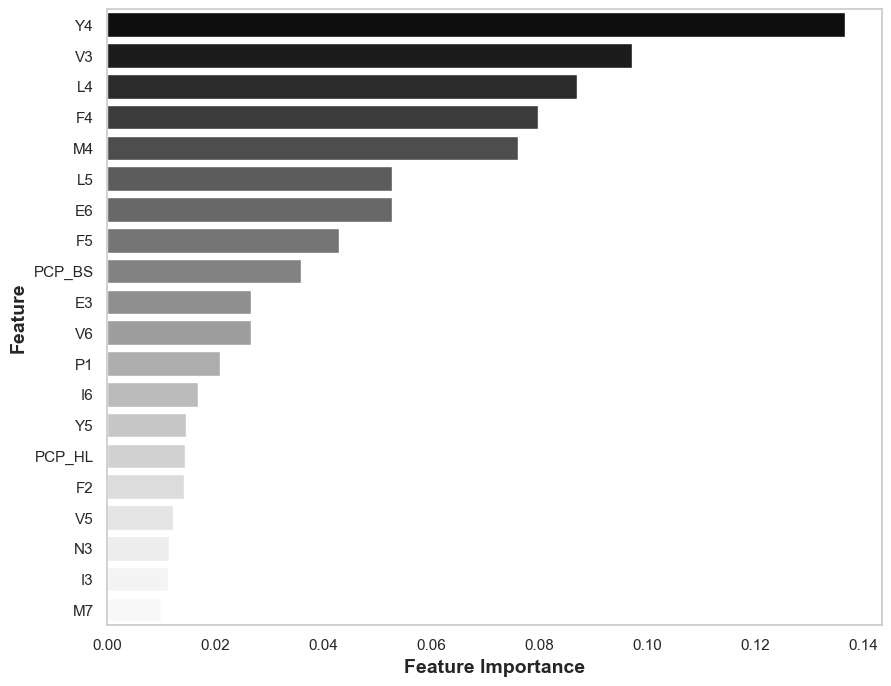

In [15]:
## Plot of feature importance
df_sorted = df1.sort_values("Gini", ascending=False)[:20]
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Gini", y="Feature", data=df_sorted, palette="Greys_r")

plt.xlabel("Feature Importance", fontsize=14, fontweight="bold")
plt.ylabel("Feature", fontsize=14, fontweight="bold")
plt.grid(False)
#plt.savefig('../results/Plot_of_feature_importance_for_GB_classifier.jpg', dpi=1200)
plt.savefig('../results/Plot_of_feature_importance_for_GB_classifier.png', dpi=1200)
plt.show()

# 10-Fold Cross Validation Experiment using the Training Dataset

In [16]:
# From previous experiments, it was noticed that Naive Bayes Classifier retuned NaN in about 3 out of the 10-Fold CV. Thus,
# in order to handle these missing values, we did the 10-Fold CV experiment of the Naive Bayes Classifier separately, handled
# the missing values before finally concatenating it to the rest of the CV result

# Instantiating the classifier classes and storing in a list
clf_list_for_CV = [(LSVM(random_state=0, tol=1e-5, C=5), "LinearSVC"),
    (LDA(solver="svd", tol=1e-8), "LinearDiscriminantAnalysis"),
    (GBC(n_estimators=800, learning_rate=1.0, max_depth=1, random_state=0, 
         tol=1e-10, ccp_alpha=0.0), "GradientBoostingClassifier"),
    (KNN(n_neighbors=4, n_jobs=-1, metric="minkowski", leaf_size=30, p=2, 
         weights="distance"), "KNeighorsClassifier"),
    (DTC(criterion="gini", splitter="best", max_depth=None, ccp_alpha=0.0), "DecisionTreeClassifier"),
    (MLPC(hidden_layer_sizes=100, activation ="relu", solver="adam", alpha=0.0001, 
          learning_rate="adaptive", max_iter=200, tol=1e-4, momentum=0.9, epsilon=1e-8,), "MLPClassifier"),
    (Perceptron(penalty="l2", alpha=0.0000001, max_iter=4000, tol=1e-7, eta0=2, n_jobs=-1), "Perceptron"),       
    (LR(random_state=0, penalty="l2", tol=1e-3, C=0.99, solver="lbfgs", max_iter=150,
       n_jobs=-1), "LogisticRegression")]

# Notice that the the instance of the Naive Bayes Classifier was not included in the list of Classifiers for the reasons
# aforementioned.

# Since specificity score is not directly included in sklearn, we create it using the make_scorer function
specificity = make_scorer(recall_score, pos_label=0) # although, this is direcly available in sklearn, but we still chose to 
sensitivity = make_scorer(recall_score, pos_label=1) # create it with the make_scorer function to avoid confusion
                                                     
scores_NBC = dd(list)
scores_other_clfs = dd(list)

metrics = [("Balanced Accuracy", "balanced_accuracy"), ("F1 Score", "f1_macro"), ("Specificity", specificity),
           ("Sensitivity", sensitivity), ("Jaccard Index", "jaccard_macro"), ("AUC", "roc_auc")]

for metric_name, metric in metrics:
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    score = cross_val_score(NBC(alpha=0), X_training, y_training, scoring=metric, cv=cv, n_jobs=-1)
    scores_NBC[metric_name].append(score) 

for clf, name in clf_list_for_CV:
    scores_other_clfs["Classifier"].append(name)
    
    for metric_name, metric in metrics:
        cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        score = cross_val_score(clf, X_training.values, y_training.values, scoring=metric, cv=cv, n_jobs=-1)
        scores_other_clfs[metric_name].append(score.mean())

In [17]:
scores_NBC

defaultdict(list,
            {'Balanced Accuracy': [array([       nan, 0.84188034, 0.85872781, 0.8495708 , 0.79246187,
                            nan, 0.82879823, 0.8255028 , 0.81208787,        nan])],
             'F1 Score': [array([       nan, 0.85540392, 0.87293072, 0.85349768, 0.8302643 ,
                            nan, 0.85002833, 0.81851553, 0.81902655,        nan])],
             'Specificity': [array([       nan, 0.96153846, 0.96745562, 0.95266272, 0.97928994,
                            nan, 0.96745562, 0.92878338, 0.94362018,        nan])],
             'Sensitivity': [array([       nan, 0.72222222, 0.75      , 0.74647887, 0.6056338 ,
                            nan, 0.69014085, 0.72222222, 0.68055556,        nan])],
             'Jaccard Index': [array([       nan, 0.75979297, 0.78457087, 0.75684489, 0.72782682,
                            nan, 0.75294715, 0.70920868, 0.71089744,        nan])],
             'AUC': [array([       nan, 0.92919954, 0.94715648, 0.93891158, 0

In [18]:
scores_other_clfs

defaultdict(list,
            {'Classifier': ['LinearSVC',
              'LinearDiscriminantAnalysis',
              'GradientBoostingClassifier',
              'KNeighorsClassifier',
              'DecisionTreeClassifier',
              'MLPClassifier',
              'Perceptron',
              'LogisticRegression'],
             'Balanced Accuracy': [0.7917012841038764,
              0.8472131502427379,
              0.8006754570876289,
              0.6848604311033503,
              0.7502717643906307,
              0.8642223667831205,
              0.5995680527023257,
              0.8641481903632645],
             'F1 Score': [0.798884885538604,
              0.8499529364735195,
              0.8065066619499998,
              0.6936433934536304,
              0.7519622826874328,
              0.8711371459243884,
              0.5327063008395669,
              0.8752747613756606],
             'Specificity': [0.9393297982547013,
              0.9502361596404054,
              0.949

# Prepare a Dataframe to Contain the Scores of the NBC

In [19]:
dic = {'Balanced Accuracy': scores_NBC['Balanced Accuracy'][0],
       'F1 Score': scores_NBC['F1 Score'][0],
       'Specificity': scores_NBC['Specificity'][0],
       'Sensitivity': scores_NBC['Sensitivity'][0],
       'Jaccard Index': scores_NBC['Jaccard Index'][0],
       'AUC': scores_NBC['AUC'][0]}

NBC = pd.DataFrame(dic)
NBC.fillna(NBC['Balanced Accuracy'].mean(), inplace=True)
NBC.fillna(NBC['F1 Score'].mean(), inplace=True)
NBC.fillna(NBC['Specificity'].mean(), inplace=True)
NBC.fillna(NBC['Sensitivity'].mean(), inplace=True)
NBC.fillna(NBC['Jaccard Index'].mean(), inplace=True)
NBC.fillna(NBC['AUC'].mean(), inplace=True)
NBC=NBC.round(2)

NBC.loc["CategoricalNB"] = NBC.mean()

NBC_df = NBC.drop([0,1,2,3,4,5,6,7,8,9], axis=0,)
NBC_df

,Balanced Accuracy,F1 Score,Specificity,Sensitivity,Jaccard Index,AUC
CategoricalNB,0.83,0.839,0.919,0.741,0.769,0.901


# Prepare a Dataframe to Store the Other Classifiers

In [20]:
other_clfs_df = pd.DataFrame(scores_other_clfs).set_index("Classifier")
other_clfs_df

,Balanced Accuracy,F1 Score,Specificity,Sensitivity,Jaccard Index,AUC
Classifier,,,,,,
LinearSVC,0.791701,0.798885,0.939330,0.644073,0.696048,0.959650
LinearDiscriminantAnalysis,0.847213,0.849953,0.950236,0.744190,0.753423,0.953187
GradientBoostingClassifier,0.800675,0.806507,0.949356,0.651995,0.707982,0.896713
KNeighorsClassifier,0.684860,0.693643,0.910273,0.459448,0.570983,0.772963
DecisionTreeClassifier,0.750272,0.751962,0.908776,0.604714,0.629178,0.759094
MLPClassifier,0.864222,0.871137,0.961495,0.798650,0.787306,0.962744
Perceptron,0.599568,0.532706,0.850525,0.348611,0.455382,0.815762
LogisticRegression,0.864148,0.875275,0.965933,0.762363,0.789302,0.963456


# Join the Two Datasets and Reindex

In [21]:
score_df = pd.concat([other_clfs_df, NBC_df], axis=0)

new_index=["LinearSVC", "LinearDiscriminantAnalysis", "GradientBoostingClassifier", "KNeighorsClassifier",
          "CategoricalNB", "DecisionTreeClassifier", "MLPClassifier", "Perceptron", "LogisticRegression"]

final_score_df = score_df.reindex(new_index).astype(float).round(decimals=3)

final_score_df

,Balanced Accuracy,F1 Score,Specificity,Sensitivity,Jaccard Index,AUC
LinearSVC,0.792,0.799,0.939,0.644,0.696,0.960
LinearDiscriminantAnalysis,0.847,0.850,0.950,0.744,0.753,0.953
GradientBoostingClassifier,0.801,0.807,0.949,0.652,0.708,0.897
KNeighorsClassifier,0.685,0.694,0.910,0.459,0.571,0.773
CategoricalNB,0.830,0.839,0.919,0.741,0.769,0.901
DecisionTreeClassifier,0.750,0.752,0.909,0.605,0.629,0.759
MLPClassifier,0.864,0.871,0.961,0.799,0.787,0.963
Perceptron,0.600,0.533,0.851,0.349,0.455,0.816
LogisticRegression,0.864,0.875,0.966,0.762,0.789,0.963


# Save the Result

In [22]:
final_score_df.to_csv("../results/Combined_10-Fold_CV_Results_(Average).csv")
score_df.to_csv("../results/Combined_10-Fold_CV_Performance_Result.xlsx")

# How to check the valid options for the scoring function of cros_val_score of sci-kit learn

In [23]:
from sklearn import metrics
# sorted(metrics.SCORERS.keys())
metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',